<a href="https://colab.research.google.com/github/mark777os/Base_of_Data/blob/master/second_Kag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Посмотрим на файлы соревнования

In [ ]:
# Импортируем библиотеки 
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import pandas as pd
from IPython.display import clear_output
from google.colab import drive
import os
%matplotlib inline

2.5.0
2.5.0


In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


Загрузим данные в массивы numpy.

In [ ]:

images = np.load('/content/drive/MyDrive/kugglDL/misis/data/images.npy')
labels = np.load('/content/drive/MyDrive/kugglDL/misis/data/labels.npy')
images_sub = np.load('/content/drive/MyDrive/kugglDL/misis/data/images_sub.npy')
print(f'images: {images.shape} of type {images.dtype}')
print(f'labels: {labels.shape} of type {labels.dtype}')
print(f'images_sub: {images_sub.shape} of type {images_sub.dtype}')

num_classes = 26 #количество классов
img_shape = (48, 48, 3) #размер изображений

images: (20000, 48, 48, 3) of type uint8
labels: (20000,) of type int64
images_sub: (50000, 48, 48, 3) of type uint8


Посмотрим, как выглядят изображения.

In [ ]:
def label_to_letter(label):
    return chr(ord('A') + label)

def show_symbols(images, labels = None, columns = 10, **kwargs):
    if labels is None: labels = [None] * len(images)
    rows = (len(images) - 1) // columns + 1
    fig = plt.figure(figsize = (25, (1.8 * 13 / columns) * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(rows, columns, i + 1)
        imshow_kwargs = {'vmin': 0, 'vmax': 255}
        imshow_kwargs.update(kwargs)
        ax.imshow(img, **imshow_kwargs)
        if label is not None: ax.set_title(label)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    fig.tight_layout(pad = 0.5)
    plt.show()

display_count = 7*3
show_symbols(
    images[:display_count],
    labels = [f'{label_to_letter(x)} ({x})' for x in labels[:display_count]],
    columns = 7
)

Посмотрим, как распределены классы в обучающих данных, а также посчитаем вероятность случайного угадывания класса.

In [ ]:
import string
plt.bar(x = list(string.ascii_uppercase), height = np.bincount(labels));
plt.show()

print(f'Вероятность случайного угадывания: {1/num_classes:.4f}')

In [ ]:
# Аугментация 
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range = [0.8,1.2],
    fill_mode='nearest'
)

# Параметры картинок
img_height = 48
img_width = 48
channels = 3
# Кол-во новых картинок
NB_of_AUG = 5

def image_augmentation(image, nb_of_augmentation):
    '''
    Создает набор картинок, созданных на основе входной
    image : картинка для аугментации
    nb_augmentation: кол-во картинок на выходе генератора
    '''
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            break
    return images

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):
    """
    images: входные изображения 
    targets: метки
    use_augmentation: использовать аугментацию
    """
    X = []
    y = []
    for x_, y_ in zip(images, targets):
               
        # Используя аугментацию
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)
        # Не используя аугментацию
        else:
            X.append(x_.reshape(img_height, img_width, channels))
            y.append(y_)
       
        
    print('Новый датасет: %i примеров\n' % len(X))
    return np.array(X), np.array(y).reshape(len(y),1)




In [ ]:
images, labels = preprocess_data(
    images , labels , 
    use_augmentation=True, 
    nb_of_augmentation=NB_of_AUG
)
labels.shape

Новый датасет: 100000 примеров



(100000, 1)

In [ ]:
# первая модель
model = keras.Sequential([
    keras.Input(shape = img_shape),
    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.45),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = 'accuracy'
)

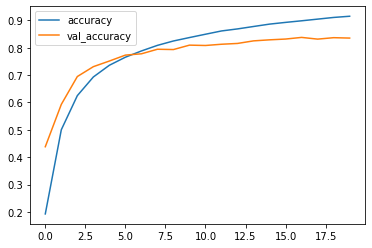

In [ ]:
images_normalized = images/255.
for epoch in range(20):
    history = model.fit(
        images_normalized, labels,
        batch_size = 16,
        validation_split = 0.15,
        epochs = 1,
        callbacks = ([model.history] if epoch > 0 else None)
    )
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

In [ ]:
predictions = model.predict(images_sub / 255.).argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # посмотрим первые 10 предсказаний

(50000,)
[19 19 14 12 10  7  5 17 23 22]


Теперь мы имеем массив из 50 тысяч предсказаний. Создаем файл submission.csv. Название файла не обязательно должно быть именно таким, главное - записать в него данные в нужном формате.

In [ ]:
import pandas as pd
submission = pd.DataFrame()
submission['Id'] = list(range(len(predictions)))
submission['Category'] = predictions
submission.to_csv('/content/drive/MyDrive/kugglDL/misis/submission3.csv', index = False)

In [ ]:


images = np.load('/content/drive/MyDrive/kugglDL/misis/data/images.npy') / 255
labels = np.load('/content/drive/MyDrive/kugglDL/misis/data/labels.npy')
images_sub = np.load('/content/drive/MyDrive/kugglDL/misis/data/images_sub.npy') / 255

In [ ]:
images= images/250.
BATCH_SIZE =12

In [ ]:
# Импортируем библиотеки 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split


В последней ячейке покажем минималистичный пример полного цикла: загрузка данных, построение модели, обучение и сабмит.

In [ ]:

K.clear_session()
model = keras.Sequential()
model.add( keras.layers.Input(shape = (48,48,3)))

model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.30))

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Dropout(0.30))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))

model.add(keras.layers.Dropout(0.4))
   
model.add(keras.layers.Dense(26, activation = 'softmax'))
model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.fit(images, labels, batch_size= BATCH_SIZE, validation_split = 0.1, epochs = 40)



NameError: ignored

In [ ]:

images_sub_normalized = images_sub / 255. 
images_sub_normalized.shape

(50000, 48, 48, 3)

In [ ]:
predictions = model.predict(images_sub).argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # посмотрим первые 10 предсказаний

(50000,)
[17  8  1 12 10  7  5 17 23 22]


In [ ]:
submission = pd.DataFrame({'Id': list(range(len(predictions))), 'Category': predictions})
submission.to_csv('/content/drive/MyDrive/kugglDL/misis/submission1.csv', index = False)

In [ ]:

model.fit(
    x=images,
    y=labels,
    batch_size=32,
    epochs=30,
    verbose=1,
    callbacks=None, #коллбеки, позволяют управлять поведением модели на каждой эпохе
    validation_split=0.1, #
    shuffle=True,#перемешивать ли выборку или нет
    class_weight=None, 
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True,
)

Epoch 1/30
563/563 [==============================] - 169s 298ms/step - loss: 0.5038 - accuracy: 0.8356 - val_loss: 0.5405 - val_accuracy: 0.8420
Epoch 2/30
563/563 [==============================] - 166s 295ms/step - loss: 0.4499 - accuracy: 0.8519 - val_loss: 0.5434 - val_accuracy: 0.8385
Epoch 3/30
563/563 [==============================] - 168s 298ms/step - loss: 0.4491 - accuracy: 0.8515 - val_loss: 0.5476 - val_accuracy: 0.8425
Epoch 4/30
563/563 [==============================] - 166s 295ms/step - loss: 0.4366 - accuracy: 0.8576 - val_loss: 0.5483 - val_accuracy: 0.8410
Epoch 5/30
563/563 [==============================] - 163s 290ms/step - loss: 0.4289 - accuracy: 0.8553 - val_loss: 0.5458 - val_accuracy: 0.8425
Epoch 6/30
563/563 [==============================] - 167s 296ms/step - loss: 0.4106 - accuracy: 0.8665 - val_loss: 0.5422 - val_accuracy: 0.8455
Epoch 7/30
563/563 [==============================] - 165s 294ms/step - loss: 0.3975 - accuracy: 0.8704 - val_loss: 0.5562 -

In [ ]:
predictions = model.predict(images_sub).argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # посмотрим первые 10 предсказаний

(50000,)
[19 11 16 12 10  7  5 17 23 22]


In [ ]:

submission = pd.DataFrame({'Id': list(range(len(predictions))), 'Category': predictions})
submission.to_csv('/content/drive/MyDrive/kugglDL/misis/submission2.csv', index = False)

In [ ]:

submission = pd.DataFrame()
submission['Id'] = list(range(len(predictions)))
submission['Category'] = predictions
submission.to_csv('/content/drive/MyDrive/kugglDL/misis/submission1.csv', index = False)